In [1]:
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import ascii
from astropy import units as u

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from scipy import ndimage

import numpy as np

<div class="alert alert-block alert-info"> <b>NOTE</b> LSBG candidates </div>

Definition of LSBG

- Freeman 1970: 
    - central surface brightness - $\mu_{B, 0}$ > 22.7 mag $arcsec^{-2}$ 
- McGaugh et al. 2001    
    - central maximum stellar surface densities - $\Sigma_{*, 0}$ < 100 $M_{\odot}$ $pc^{-2}$

### bulge
- Sersic profile: ***Photo-Bulge***
    - $\Sigma(r) = \Sigma_{e}\exp{(-k((\frac{r}{r_{e}})^{\frac{1}{n}} - 1))}$, surface brightness at radius r
    - $k = 1.9992n - 0.3271$
    
- de Vaucoulers profile:
    - $n = 4$ 
    - bulge of late-type spiral (n = 1), bright ellipticals / bulge of early-type spiral (n = 4)
    
### disk
- exponential profile: ***Photo-Disk***
    - $\Sigma(r) = \Sigma_{0}\exp{(-\frac{r}{r_{d}})}$
    - $\Sigma_{0} = central surface brightness$, $r_{d} = disc scale length$

- Simard+02, GIM2D
    - THE DEEP GROTH STRIP SURVEY. II. HUBBLE SPACE TELESCOPE STRUCTURAL PARAMETERS OF GALAXIES IN THE GROTH STRIP
    
- Simard+11, disc+bulge decomposition
    - A CATALOG OF BULGE+DISK DECOMPOSITIONS AND UPDATED PHOTOMETRY FOR 1.12 MILLION GALAXIES IN THE SLOAN DIGITAL SKY SURVEY
    
- Bottrell+19, Stripe82
    - Bulge plus disc and S¢¥ersic decomposition catalogues for 16,908 galaxies in the SDSS Stripe 82 co-adds: A detailed study of the ugriz structural measurements
 

# Galaxy catalog: Bottrell+19

- (ps) single-component Sersic profile
- (n4) two-component nb = 4 bulge and exponential disc
- (fn) two-component free-nb bulge and exponential disc

### 1. Bulge/Disk Decomposition

In [2]:
from utils.decomposition import bulge, disk

In [3]:
# fn catalog
cat = Table.read("./data/s82grfn.fit")

NOTE.

Assume $a$ is a radius of galactic disc (circle) and $inc$ (inclination) = $cos(a/b)$ (Notation from Bottrell+19)

$F_{disc} \times cos(\theta)= F_{obs}$

where F is surface density

In [20]:
# radius in [kpc]
radii = np.arange(0.01, 20, 0.01) 

# calculate surface-brightness at r = 0
mu0_cat = []

for idx in range(len(cat)):
# for idx in range(10):
  
    #### Bulge-to-total fraction on the g-band
    btt = cat['B_Tg'][idx]

    #### flux per area
    # fit bulge effective radius [kpc] & sersic index into flux profile
    flux_bulge_arb = bulge(r = radii, Sig_e = 10, r_e = cat['radbkpc'][idx], n = cat['n'][idx])
    # disk scale length [kpc] into flux profile
    flux_disk_arb = disk(r = radii, Sig_0 = 10, r_d = cat['raddkpc'][idx])
    flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt
    ############################ EDITED  ############################
    # inclination correction (inc: degree -> radian)
    flux_disk_arb = flux_disk_arb * (np.cos(cat['inc'][idx] * np.pi / 180))
    ############################ EDITED  ############################
    

    ##### Petrosian radius R50 on the g-band [arcsec]
    petro_r50_arc = cat['R50g'][idx]
    # angular diameter distance [physical transverse distance Mpc to an angle of 1 radian at redshift z]
    d_A = cosmo.angular_diameter_distance(z = cat['z'][idx]).value
    # R50 in [kpc]
    petro_r50_kpc = d_A/206265*1000 * (petro_r50_arc)
    
    petro_r50_idx = int(petro_r50_kpc // 0.01)

    #flux within r50 to SB
    flux_bulge_arb_r50 = flux_bulge_arb[:petro_r50_idx]
    flux_disk_arb_r50 = flux_disk_arb[:petro_r50_idx]
    flux_total_arb_r50 = flux_bulge_arb_r50 + flux_disk_arb_r50

    flux_avg_r50 = [flux_total_arb_r50[ii] * 2 * np.pi * 0.01**2 * (ii+1) for ii in range(len(flux_total_arb_r50))] 
    flux_avg_r50 = np.sum(flux_avg_r50) / (np.pi * petro_r50_kpc**2)

    ### Average surface brightness in R50 on the g-band [mag/arc^2]
    # zeropoint 30
    zp = 30
    factor = 10**((cat['mu50g'][idx] - zp) / -2.5) / flux_avg_r50
    flux_bulge_corr = flux_bulge_arb * factor
    flux_disk_corr = flux_disk_arb * factor
    flux_total = flux_bulge_corr + flux_disk_corr
    # flux_corr = 10**((sb_arb - 30) / -2.5) * factor
    sb_bulge_corr = -2.5 * np.log10(flux_bulge_corr) + zp
    sb_disk_corr = -2.5 * np.log10(flux_disk_corr) + zp
    sb_total = -2.5 * np.log10(flux_total) + zp
    
    mu0 = sb_disk_corr[0]
    mu0_cat.append(mu0)

mu0_cat = np.array(mu0_cat)

/tmp/ipykernel_30067/1093832277.py:18: RuntimeWarning: invalid value encountered in double_scalars
  flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt
/tmp/ipykernel_30067/1093832277.py:40: RuntimeWarning: invalid value encountered in double_scalars
  flux_avg_r50 = np.sum(flux_avg_r50) / (np.pi * petro_r50_kpc**2)
/tmp/ipykernel_30067/1093832277.py:50: RuntimeWarning: divide by zero encountered in log10
  sb_bulge_corr = -2.5 * np.log10(flux_bulge_corr) + zp
/tmp/ipykernel_30067/1093832277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt
/tmp/ipykernel_30067/1093832277.py:47: RuntimeWarning: invalid value encountered in multiply
  flux_disk_corr = flux_disk_arb * factor
/tmp/ipykernel_30067/1093832277.py:51: RuntimeWarning: divide by zero encountered in log10
  sb_disk_corr = -2.5 * np.log10(flux_disk_corr) + zp


/tmp/ipykernel_30067/1093832277.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  factor = 10**((cat['mu50g'][idx] - zp) / -2.5) / flux_avg_r50
/tmp/ipykernel_30067/1093832277.py:46: RuntimeWarning: invalid value encountered in multiply
  flux_bulge_corr = flux_bulge_arb * factor


Text(0, 0.5, 'count')

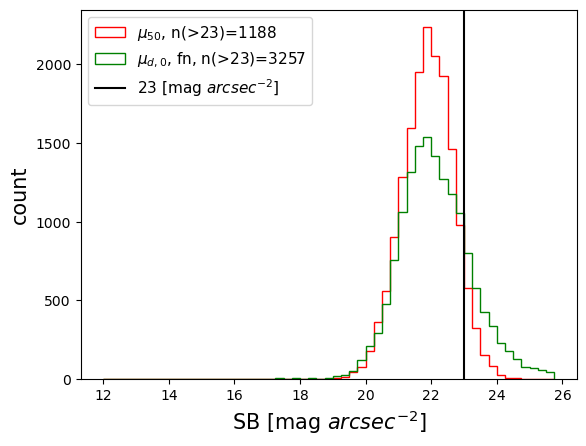

In [21]:
fig, ax = plt.subplots()
mu50num = sum(cat['mu50g'] > 23)

ax.hist(cat['mu50g'], bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', color = 'red', label = '$\mu_{50}$'+ f', n(>23)={mu50num}')
ax.hist(mu0_cat, bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', color = 'green', label = '$\mu_{d, 0}$, fn' + f', n(>23)={sum(mu0_cat > 23)}')

ax.axvline(23, color = 'black', label = '23 [mag $arcsec^{-2}$]')

ax.legend(fontsize = 11, loc = 'upper left')

ax.set_xlabel(r'SB [mag $arcsec^{-2}$]', fontsize = 15)
ax.set_ylabel('count', fontsize = 15)

### 2. LSBG sample selection

* redshift: $0< z < 0.055$
* inclination: $25\degree<\theta <75\degree$
* surface brightness: $\sim23$


In [22]:
z_mask = (cat['z'] > 0.015) & (cat['z'] < 0.055)
inclination_mask = (cat['inc'] <= 75) & (cat['inc'] >= 25)

sb_mask = mu0_cat > 23

# lsb vs. hsb
lsb_mask = (z_mask & inclination_mask) & sb_mask
hsb_mask = (z_mask & inclination_mask) & ~sb_mask

print(f'LSBG: {sum(lsb_mask)}')
print(f'HSBG: {sum(hsb_mask)}')

LSBG: 415
HSBG: 2029


Text(0, 0.5, 'count')

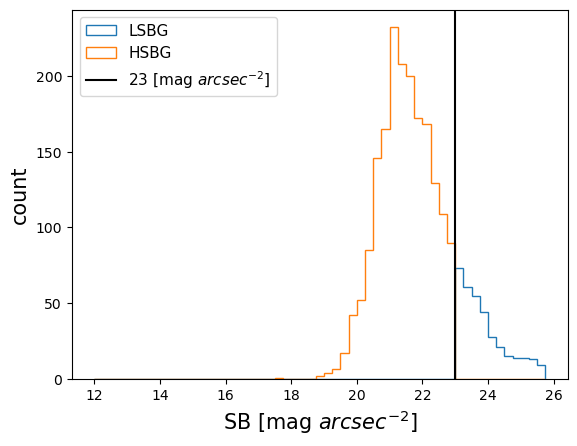

In [23]:
fig, ax = plt.subplots()
mu50num = sum(cat['mu50g'] > 23)

ax.hist(mu0_cat[lsb_mask], bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', label = 'LSBG')
ax.hist(mu0_cat[hsb_mask], bins = np.arange(12, 26, 0.25), alpha = 1, histtype = 'step', label = 'HSBG')

ax.axvline(23, color = 'black', label = '23 [mag $arcsec^{-2}$]')

ax.legend(fontsize = 11, loc = 'upper left')

ax.set_xlabel(r'SB [mag $arcsec^{-2}$]', fontsize = 15)
ax.set_ylabel('count', fontsize = 15)

# Comparison

Text(0.5, 0, 'bulge effective radius [kpc]')

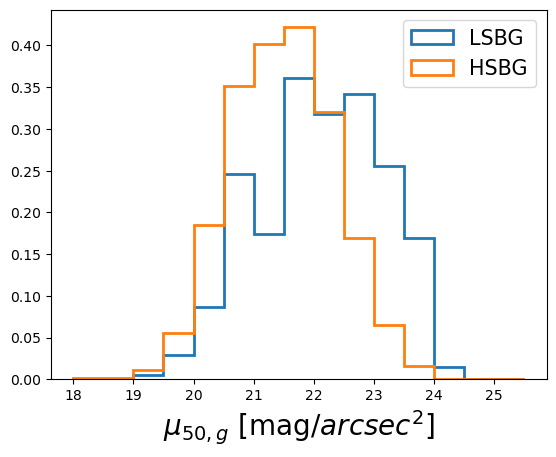

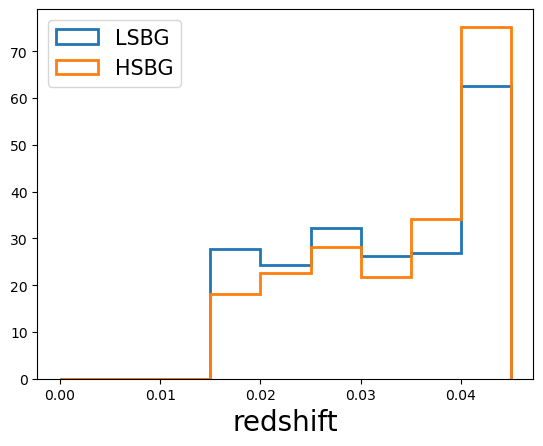

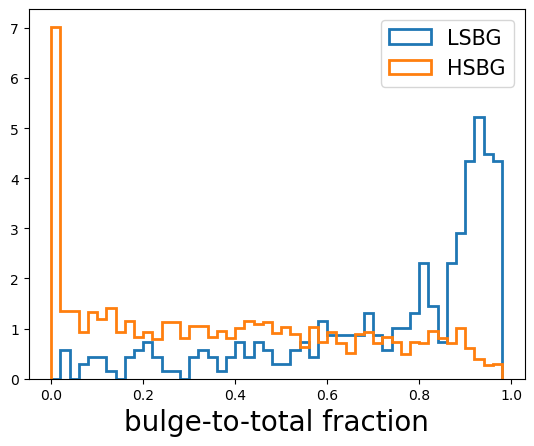

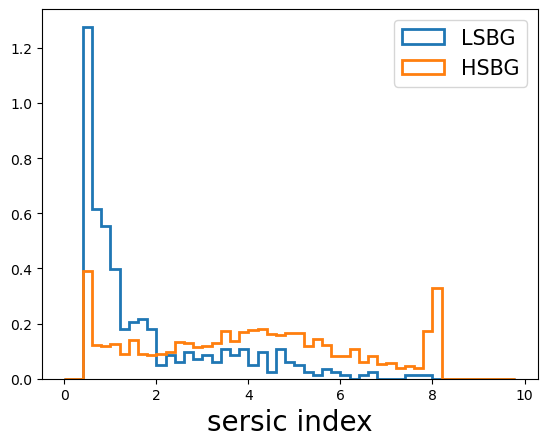

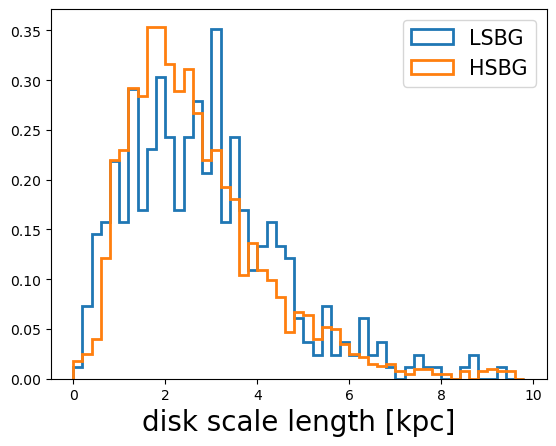

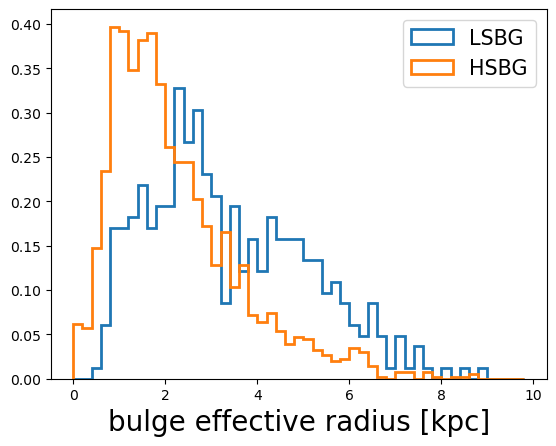

In [24]:
# mu50g
plt.figure()
plt.hist(cat[lsb_mask]['mu50g'], bins = np.arange(18, 26, 0.5), histtype = 'step', linewidth = 2, label = 'LSBG', density = sum(lsb_mask)/len(cat))
plt.hist(cat[hsb_mask]['mu50g'], bins = np.arange(18, 26, 0.5), histtype = 'step', linewidth = 2, label = 'HSBG', density = sum(hsb_mask)/len(cat))
plt.legend(fontsize = 15)
plt.xlabel('$\mu_{50, g}$ [mag/$arcsec^{2}$]', fontsize = 20)

# redshift
plt.figure()
plt.hist(cat[lsb_mask]['z'], bins = np.arange(0, 0.05, 0.005), histtype = 'step', linewidth = 2, label = 'LSBG', density = sum(lsb_mask)/len(cat))
plt.hist(cat[hsb_mask]['z'], bins = np.arange(0, 0.05, 0.005), histtype = 'step', linewidth = 2, label = 'HSBG', density = sum(hsb_mask)/len(cat))
plt.legend(fontsize = 15)
plt.xlabel('redshift', fontsize = 20)

# bulge-to-total fraction
plt.figure()
plt.hist(cat[lsb_mask]['B_Tg'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'LSBG', density = sum(lsb_mask)/len(cat))
plt.hist(cat[hsb_mask]['B_Tg'], bins = np.arange(0, 1, 0.02), histtype = 'step', linewidth = 2, label = 'HSBG', density = sum(hsb_mask)/len(cat))
plt.legend(fontsize = 15)
plt.xlabel('bulge-to-total fraction', fontsize = 20)

# sersic index
plt.figure()
plt.hist(cat[lsb_mask]['n'], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG', density = sum(lsb_mask)/len(cat))
plt.hist(cat[hsb_mask]['n'], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG', density = sum(hsb_mask)/len(cat))
plt.legend(fontsize = 15)
plt.xlabel('sersic index', fontsize = 20)

# disc scale length
plt.figure()
plt.hist(cat['raddkpc'][lsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG', density = sum(lsb_mask)/len(cat))
plt.hist(cat['raddkpc'][hsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG', density = sum(hsb_mask)/len(cat))
plt.legend(fontsize = 15)
plt.xlabel('disk scale length [kpc]', fontsize = 20)

# bulge effective radius
plt.figure()
plt.hist(cat['radbkpc'][lsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'LSBG', density = sum(lsb_mask)/len(cat))
plt.hist(cat['radbkpc'][hsb_mask], bins = np.arange(0, 10, 0.2), histtype = 'step', linewidth = 2, label = 'HSBG', density = sum(hsb_mask)/len(cat))
plt.legend(fontsize = 15)
plt.xlabel('bulge effective radius [kpc]', fontsize = 20)


# Conversion?

B = g + 0.47(g-r) + 0.17

$\mu_{0}(m) = m + 2.5\log{(2\pi a^{2})} + 2.5\log{(b/a)} - 10\log{(1+z)}$

In [25]:
# converted B
B_conv = cat['gmag'] + 0.47 * (cat['gmag'] - cat['rmag']) + 0.17

# Galaxy half-light radius (kpc) on the g-band
a = cat['hlrgkpc']

# b over a
bovera = np.arccos(cat['inc'] * np.pi / 180)

# converted mu_B
muB_conv = B_conv + 2.5 * np.log10(2 * np.pi * a**2) + 2.5 * np.log10(bovera) - 10 * np.log10(1 + cat['z'])

/tmp/ipykernel_30067/339305492.py:8: RuntimeWarning: invalid value encountered in arccos
  bovera = np.arccos(cat['inc'] * np.pi / 180)
/tmp/ipykernel_30067/339305492.py:11: RuntimeWarning: divide by zero encountered in log10
  muB_conv = B_conv + 2.5 * np.log10(2 * np.pi * a**2) + 2.5 * np.log10(bovera) - 10 * np.log10(1 + cat['z'])


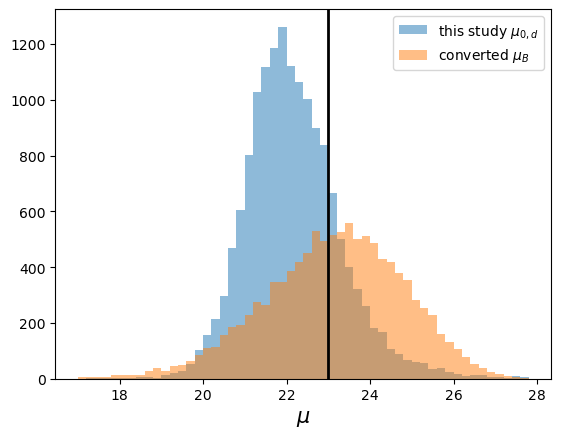

In [26]:
plt.hist(mu0_cat, bins = np.arange(17, 28, 0.2), alpha = .5, label = 'this study $\mu_{0, d}$')
plt.hist(muB_conv, bins = np.arange(17, 28, 0.2), alpha = .5, label = 'converted $\mu_{B}$')

plt.axvline(23, color = 'black', linewidth = 2)

plt.xlabel('$\mu$', fontsize = 15)
plt.legend()
